In [1]:
pip -q install SciencePlots

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from gnd.src import basis, data

In [5]:
plt.style.use('science')
fontsize_title=22
fontsize_label=18
fontsize_legend=16
fontsize_ticks=16

In [6]:
def plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, title):
    plt.figure(figsize=(8,5))
    plt.title(title, fontsize=fontsize_title)
    plt.hist(num_steps_gnd, bins=[i+1 for i in range(110)], alpha=0.5, label="Geodesic algorithm")
    plt.hist(num_steps_sgd, bins=[i+1 for i in range(110)], alpha=0.5, label="Stochastic gradient descent")
    plt.hist(num_steps_jaxgd, bins=[i+1 for i in range(110)], alpha=0.5, label="JAX gradient descent")
    plt.xticks([0,20,40,60,80,100], fontsize=fontsize_ticks)

    plt.xlabel("Steps to solution", fontsize=fontsize_label)
    plt.ylabel(f"Number of solutions ({ntrials} trials)", fontsize=fontsize_label)
    plt.legend(fontsize=fontsize_legend)
    plt.savefig(f"{name}.pdf", bbox_inches='tight')
    plt.show()

In [7]:
def plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, title):

    plt.figure(figsize=(4,4))
    plt.title(title, fontsize=fontsize_title)
    plt.scatter(num_steps_gnd, 1-  np.abs(max_fidelity_gnd), alpha=0.5, s=50)
    plt.xlabel(f"Steps to solution", fontsize=fontsize_label)
    plt.ylabel(f"Maximum infidelity", fontsize=fontsize_label)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1, 10**4+1000)
    plt.ylim(1e-6, 1.)
    plt.savefig(f"{name}.pdf", bbox_inches='tight')
    plt.show()

In [8]:
def get_data_comparison(config, config_gnd, seeds):
    num_steps_gnd = []
    num_steps_sgd = []
    num_steps_jaxgd = []
    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        config_gnd.seed = seed

        dat_gnd = data.OptimizationData(config_gnd, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            num_steps_gnd.append(dat_gnd.steps(1)[-1])
        dat_sgd = data.OptimizationData(config, optimizers=[], load_data=True, folder="innocenti/data")
        if dat_sgd.samples > 0:
            num_steps_sgd.append(dat_sgd.steps(1)[-1])
        dat_jaxgd = data.OptimizationData(config, optimizers=[], load_data=True, folder="jax_gd/data")
        if dat_jaxgd.samples > 0:
            num_steps_jaxgd.append(dat_jaxgd.steps(1)[-1])
    return num_steps_gnd, num_steps_sgd, num_steps_jaxgd

In [9]:
def get_data_fidelity(config, seeds):
    num_steps_gnd = []
    max_fidelity_gnd = []

    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        dat_gnd = data.OptimizationData(config, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            max_fidelity_gnd.append(dat_gnd.max_fidelity(1))
            num_steps_gnd.append(dat_gnd.steps(1)[-1])
    
    return num_steps_gnd, max_fidelity_gnd

# Data aggregation

In [10]:
loaded_data = {}

# Toffoli

### Commuting

In [11]:
from gnd.src.configs import ToffoliConfig as ToffoliConfigGnd
from jax_gd.src.configs import ToffoliConfig

config = ToffoliConfig()
config_gnd = ToffoliConfigGnd()

gate = 'toffoli'
ntrials = 1000
commute = True
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

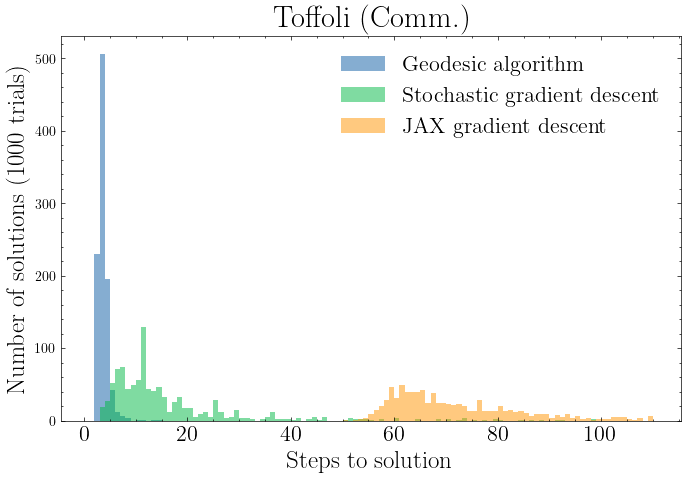

In [12]:
gate = 'toffoli'
ntrials = 1000
commute = True
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, 
                f"Toffoli ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [13]:
from gnd.src.configs import ToffoliConfig as ToffoliConfigGnd
from jax_gd.src.configs import ToffoliConfig

config = ToffoliConfig()
config_gnd = ToffoliConfigGnd()

gate = 'toffoli'
ntrials = 1000
commute = False
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

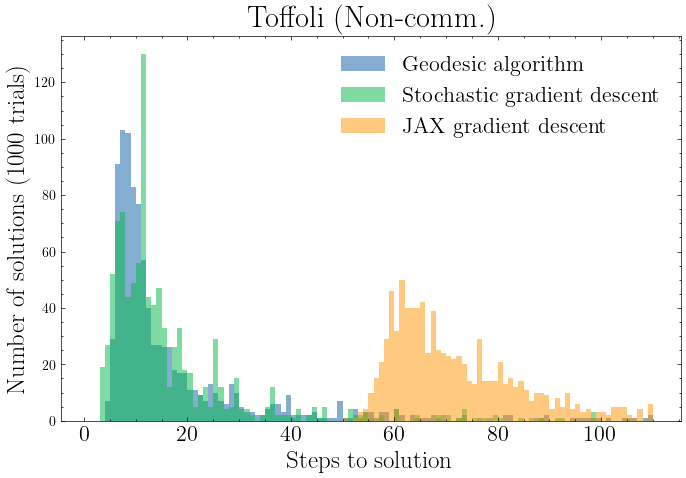

In [14]:
gate = 'toffoli'
ntrials = 1000
commute = False
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, 
                f"Toffoli ({'Comm.' if commute else 'Non-comm.'})")

# Fredkin

### Commuting

In [15]:
from gnd.src.configs import FredkinConfig as FredkinConfigGnd
from jax_gd.src.configs import FredkinConfig

config = FredkinConfig()
config_gnd = FredkinConfigGnd()

gate = 'fredkin'
ntrials = 1000
commute = True
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

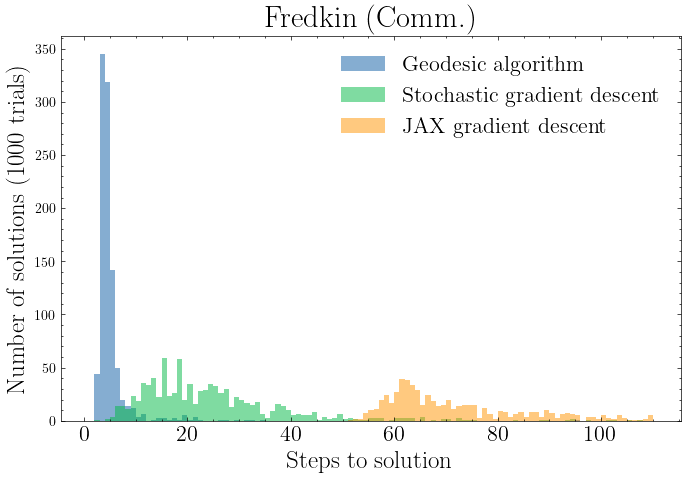

In [16]:
gate = 'fredkin'
ntrials = 1000
commute = True
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"Fredkin ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [17]:
from gnd.src.configs import FredkinConfig as FredkinConfigGnd
from jax_gd.src.configs import FredkinConfig

config = FredkinConfig()
config_gnd = FredkinConfigGnd()

gate = 'fredkin'
ntrials = 1000
commute = False
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

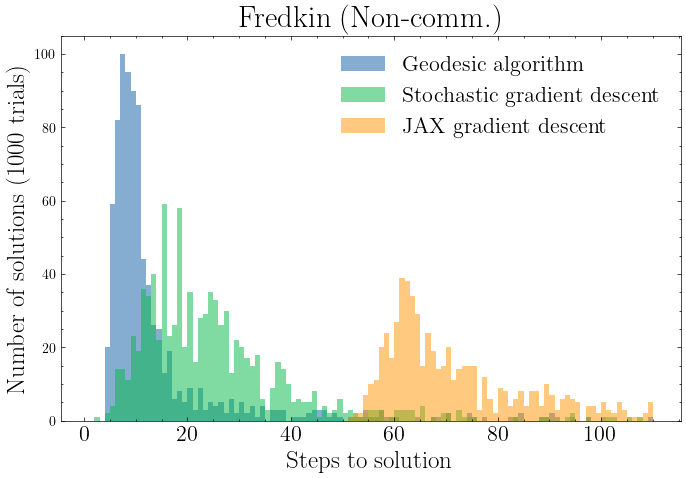

In [18]:
gate = 'fredkin'
ntrials = 1000
commute = False
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"Fredkin ({'Comm.' if commute else 'Non-comm.'})")

# C4Not

### Commuting

In [19]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd
from jax_gd.src.configs import CxNotConfig

config = CxNotConfig(4)
config_gnd = CxNotConfigGnd(4)

gate = 'c4not'
ntrials = 1000
commute = True
max_steps = 5000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

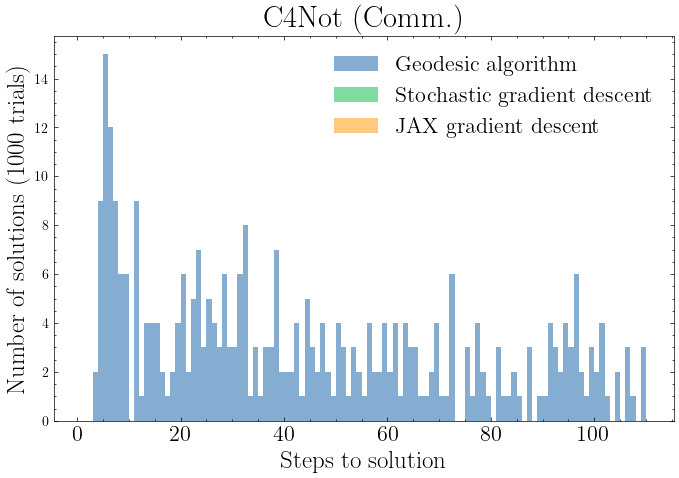

In [20]:
gate = 'c4not'
ntrials = 1000
commute = True
max_steps = 5000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"C4Not ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [21]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd
from jax_gd.src.configs import CxNotConfig

config = CxNotConfig(4)
config_gnd = CxNotConfigGnd(4)

gate = 'c4not'
ntrials = 1000
commute = False
max_steps = 5000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

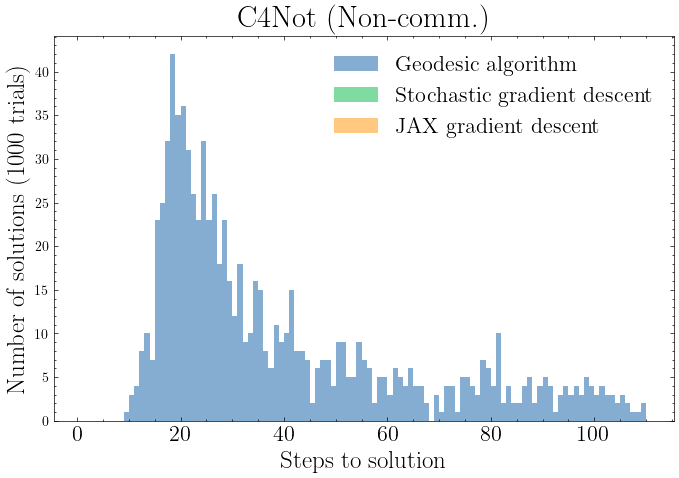

In [22]:
gate = 'c4not'
ntrials = 1000
commute = False
max_steps = 5000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"C4Not ({'Comm.' if commute else 'Non-comm.'})")

# Fidelity plots
We only consider the non-commuting options here.

# C5Not

### Commuting

In [23]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd

config = CxNotConfigGnd(5)

gate = 'c5not'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

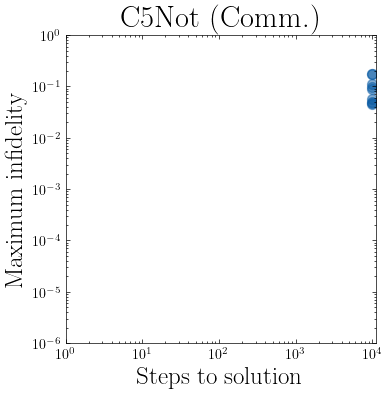

In [24]:
gate = 'c5not'
ntrials = 10
commute = True
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"C5Not ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [25]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd

config = CxNotConfigGnd(5)

gate = 'c5not'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

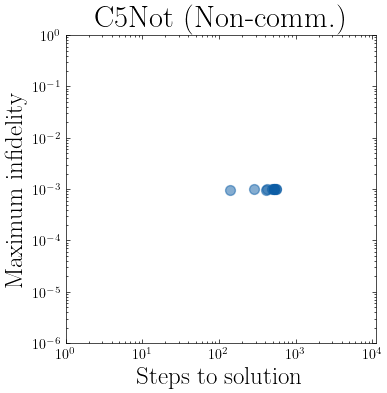

In [26]:
gate = 'c5not'
ntrials = 10
commute = False
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"C5Not ({'Comm.' if commute else 'Non-comm.'})")

# Weight3ParityX

### Commuting

In [27]:
from gnd.src.configs import Weight3ParityXConfig

config = Weight3ParityXConfig()

gate = 'w3px'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

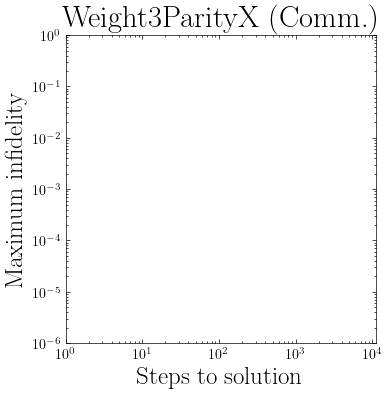

In [28]:
gate = 'w3px'
ntrials = 10
commute = True
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight3ParityX ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [29]:
from gnd.src.configs import Weight3ParityXConfig

config = Weight3ParityXConfig()

gate = 'w3px'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

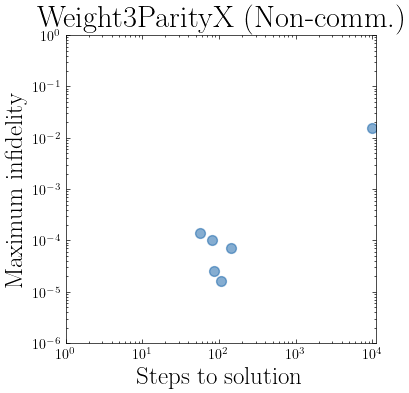

In [30]:
gate = 'w3px'
ntrials = 10
commute = False
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight3ParityX ({'Comm.' if commute else 'Non-comm.'})")

# Weight3ParityZ

### Commuting

In [31]:
from gnd.src.configs import Weight3ParityZConfig

config = Weight3ParityZConfig()

gate = 'w3pz'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

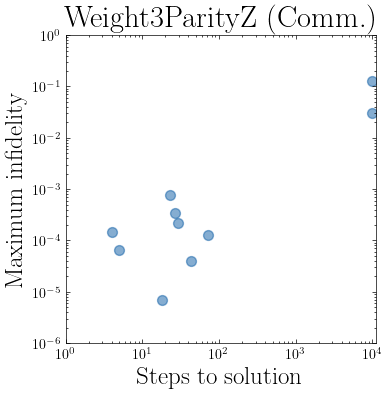

In [32]:
gate = 'w3pz'
ntrials = 10
commute = True
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight3ParityZ ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [33]:
from gnd.src.configs import Weight3ParityZConfig

config = Weight3ParityZConfig()

gate = 'w3pz'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

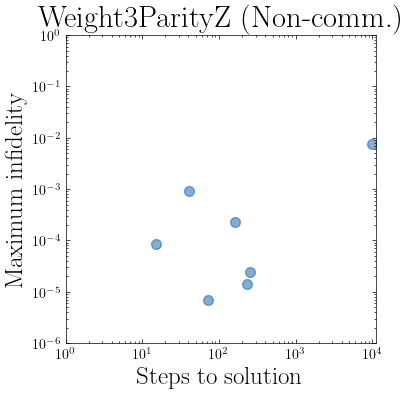

In [34]:
gate = 'w3pz'
ntrials = 10
commute = False
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight3ParityZ ({'Comm.' if commute else 'Non-comm.'})")

# Weight4ParityX

### Commuting

In [35]:
from gnd.src.configs import Weight4ParityXConfig

config = Weight4ParityXConfig()

gate = 'w4px'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

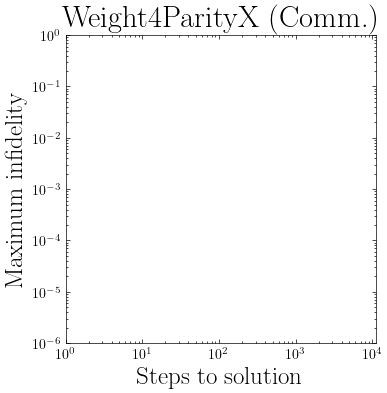

In [36]:
gate = 'w4px'
ntrials = 10
commute = True
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight4ParityX ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [37]:
from gnd.src.configs import Weight4ParityXConfig

config = Weight4ParityXConfig()

gate = 'w4px'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

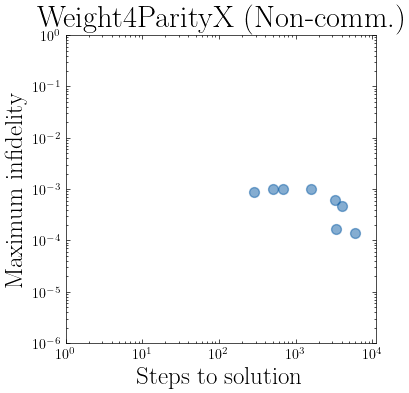

In [38]:
gate = 'w4px'
ntrials = 10
commute = False
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight4ParityX ({'Comm.' if commute else 'Non-comm.'})")

# Weight4ParityZ

### commuting

In [39]:
from gnd.src.configs import Weight4ParityZConfig

config = Weight4ParityZConfig()

gate = 'w4pz'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

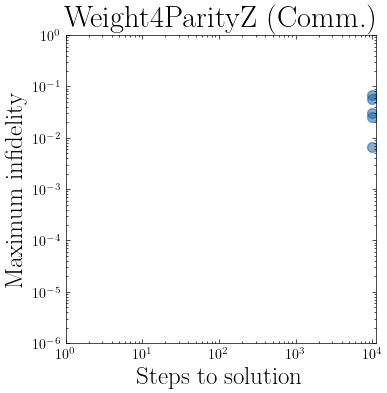

In [40]:
gate = 'w4pz'
ntrials = 10
commute = True
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight4ParityZ ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [41]:
from gnd.src.configs import Weight4ParityZConfig

config = Weight4ParityZConfig()

gate = 'w4pz'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

max_fidelity_gnd, num_steps_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (max_fidelity_gnd, num_steps_gnd)

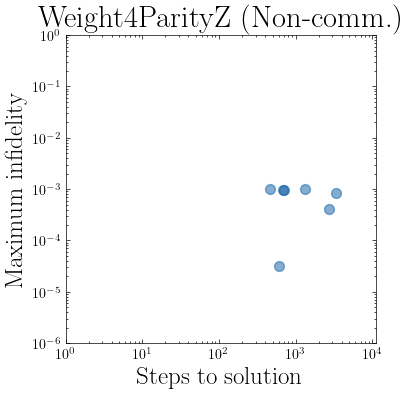

In [42]:
gate = 'w4pz'
ntrials = 10
commute = False
max_steps = 10000

max_fidelity_gnd, num_steps_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(max_fidelity_gnd, num_steps_gnd, name, f"Weight4ParityZ ({'Comm.' if commute else 'Non-comm.'})")